In [14]:
import os

import numpy as np
import xarray as xr
import rioxarray as rxr

import gval

from mosaic_inundation import Mosaic_inundation
from inundate_gms import Inundate_gms

In [7]:
fim_dir = '/foss_fim/data/12020001'
benchmark_flows = f'{fim_dir}/ble_huc_12020001_flows_500yr.csv'
gms_workers = 1
huc = ['12020001']
predicted_raster_path = '/foss_fim/outputs/test.tif'
verbose = False
log_file = f'{fim_dir}/gms.log'
elev_raster_ndv = -9999
map_file = Inundate_gms(hydrofabric_dir=os.path.dirname(fim_dir),
                        forecast=benchmark_flows,
                        num_workers=gms_workers,
                        hucs=huc,
                        inundation_raster=predicted_raster_path,
                        inundation_polygon=None,
                        depths_raster=None,
                        verbose=verbose,
                        log_file=log_file,
                        output_fileNames=None)

mosaiced_inundation = Mosaic_inundation(map_file,
                                        mosaic_attribute='inundation_rasters',
                                        mosaic_output=predicted_raster_path,
                                        mask=os.path.join(fim_dir, 'wbd.gpkg'),
                                        unit_attribute_name='huc8',
                                        nodata=elev_raster_ndv,
                                        workers=1,
                                        remove_inputs=True,
                                        subset=None,
                                        verbose=verbose)

In [11]:
candidate = rxr.open_rasterio(predicted_raster_path, mask_and_scale=True)
benchmark = rxr.open_rasterio('/foss_fim/data/ble_huc_12020001_extent_500yr.tif', mask_and_scale=True)

In [16]:
candidate.data = xr.where(candidate < 0, 0, candidate)
candidate.data = xr.where(candidate > 0, 1, candidate)

In [18]:
target_map, cross_tab, metric_df = candidate.gval.categorical_compare(benchmark,
                                                                      positive_categories=[1],
                                                                      negative_categories=[0])

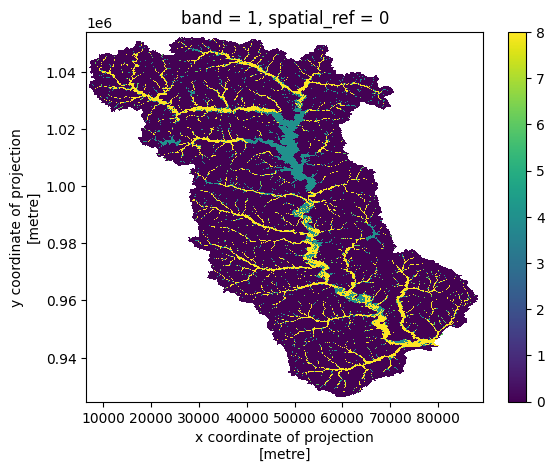

In [19]:
target_map.plot()

In [20]:
cross_tab

,band,candidate_values,benchmark_values,agreement_values,counts
0,1,0.0,0.0,0.0,41909587.0
1,1,1.0,0.0,6.0,328533.0
2,1,0.0,1.0,4.0,3295863.0
3,1,1.0,1.0,8.0,4710516.0


In [21]:
metric_df

,band,fn,fp,tn,tp,accuracy,critical_success_index,f_score,false_discovery_rate,false_negative_rate,...,fowlkes_mallows_index,matthews_correlation_coefficient,negative_likelihood_ratio,negative_predictive_value,positive_likelihood_ratio,positive_predictive_value,prevalence,prevalence_threshold,true_negative_rate,true_positive_rate
0,1,3295863.0,328533.0,41909587.0,4710516.0,0.927865,0.565155,0.722171,0.065197,0.411655,...,0.741611,0.707381,0.414882,0.927091,75.641114,0.934803,0.100291,0.103123,0.992222,0.588345
